# Modelo Determinación de Centro Poblado a partir de poligonos y puntos

Se necesita: 
- Capa de poligonos formados (de manera independiente)
- Capa de puntos de viviendas de centros poblados

# Preparación de datos (formación de las capas mencionadas)

In [35]:
import rasterio
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon

In [2]:
import pandas as pd

In [37]:
geometrias_centros_poblados_validas=gpd.read_file('geometrias_manuales_finales_validas_rural_urbano.gpkg')

In [38]:
geometrias_centros_poblados_validas_rural=geometrias_centros_poblados_validas[geometrias_centros_poblados_validas.AREA_17==2]

In [5]:
def clasificar_vivienda(columna):
    if columna.__contains__('POB'):
        return 'CAPA DE VIVIENDA - CENTROS POBLADOS NUEVOS'
    elif columna.__contains__('VIVIENDA'):
        return 'CAPA DE VIVIENDA'
    elif columna.__contains__('ANTIGUA'):
        return 'CAPA CENTROS POBLADOS ANTIGUA'
    else:
        return 'RARO'

In [6]:
geometrias_centros_poblados_validas_rural['CAPA A USAR']=geometrias_centros_poblados_validas_rural['CAPA A USAR'].apply(clasificar_vivienda)

c:\Users\Rofer\anaconda3\envs\nuevo_entorno\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [15]:
centrospobladosineinuevos=gpd.read_file(r"C:\Users\Rofer\OneDrive\Escritorio\INEI\Proyecto Integrador\Datos Espaciales\INFORMACION_ZONAS_2017\INFORMACION_ZONAS_2017\CENTROS_POBLADOS_2017.shp")
centrospobladosineinuevos=centrospobladosineinuevos.to_crs(crs=geometrias_centros_poblados_validas_rural.crs)

In [33]:
centrospobladosantiguos=gpd.read_file('C:/Users/Rofer/OneDrive/Escritorio/INEI/Proyecto Integrador/Imagenes/CO_2509192038283/VOL_PER1_ORT_001_000042/IMG_PER1_ORT_PMS_000042/PUEBLOSENMARCADOS_IMG_PER1_20161031153102_ORT_PMS_000042.gpkg')
centrospobladosantiguos=centrospobladosantiguos.to_crs(crs=geometrias_centros_poblados_validas_rural.crs)

In [40]:
viviendas=gpd.read_file(r"C:\Users\Rofer\OneDrive\Escritorio\INEI\Proyecto Integrador\Datos Espaciales\INFORMACION_ZONAS_2017\INFORMACION_ZONAS_2017\VIVIENDAS_RURALES_2017.shp")
viviendas=viviendas.to_crs(crs=geometrias_centros_poblados_validas_rural.crs)

In [24]:
viviendas['IDCCPP_17'] = viviendas['UBIGEO'].astype(str) + viviendas['CODCCPP'].astype(str)

In [29]:
geometrias_centros_poblados_validas_rural['CAPA A USAR'].value_counts()

CAPA A USAR
CAPA DE VIVIENDA                              87
CAPA CENTROS POBLADOS ANTIGUA                  1
CAPA DE VIVIENDA - CENTROS POBLADOS NUEVOS     1
RARO                                           1
Name: count, dtype: int64

Centros Poblados Antiguos

In [30]:
cpantiguos=geometrias_centros_poblados_validas_rural[geometrias_centros_poblados_validas_rural['CAPA A USAR']=='CAPA CENTROS POBLADOS ANTIGUA'].IDCCPP_17.values

In [35]:
A=centrospobladosantiguos[centrospobladosantiguos.IDCCPP_17.isin(cpantiguos)]

Capa de vivienda - centros poblados nuevos

In [37]:
cpfaltante=geometrias_centros_poblados_validas_rural[geometrias_centros_poblados_validas_rural['CAPA A USAR']=='CAPA DE VIVIENDA - CENTROS POBLADOS NUEVOS'].IDCCPP_17.values

In [38]:
B=centrospobladosineinuevos[centrospobladosineinuevos.IDCCPP_17.isin(cpfaltante)]

In [44]:
viviendasxcentropoblados=gpd.GeoDataFrame(pd.concat([A,B,viviendas]), crs=geometrias_centros_poblados_validas_rural.crs)

In [ ]:
viviendasxcentropoblados

# Análisis a nivel de polígono

In [75]:
poligonos_geometrias_centros_poblados_validas_rural=geometrias_centros_poblados_validas_rural.explode(index_parts=False).reset_index(drop=True)

In [48]:
#leer los poligonos de train:
splits=gpd.read_file(r"C:\Users\Rofer\OneDrive\Escritorio\INEI\Proyecto Integrador\tiles_spatial_split_4x4.shp")

In [ ]:
trainsplit=splits[splits.split.isin(['train', 'val'])] #se junta los train + valid, 88% de los pixeles funcionales
testsplit=splits[splits.split=='test']

In [ ]:
train_viviendasxcentropoblados=viviendasxcentropoblados.sjoin(trainsplit) # se forma los puntos de viviendas de train

In [ ]:
test_viviendasxcentropoblados=viviendasxcentropoblados.sjoin(testsplit) # se forma también los puntos de viviendas de test

In [ ]:
train_geometrias_centros_poblados_validas_rural=poligonos_geometrias_centros_poblados_validas_rural.sjoin(trainsplit) #se recortan las geometrías que se intersectan dentro de los train splits

In [ ]:
import folium

# --------------------------------------------------
# 0. Reproyectar a WGS84 (Folium solo entiende EPSG:4326)
# --------------------------------------------------
gdf_poly = train_geometrias_centros_poblados_validas_rural.to_crs(4326)
gdf_pts  = train_viviendasxcentropoblados.to_crs(4326)

# --------------------------------------------------
# 1. Calcular centro
# --------------------------------------------------
bounds = gdf_poly.total_bounds
minx, miny, maxx, maxy = bounds
centro = [(miny + maxy) / 2, (minx + maxx) / 2]

m = folium.Map(location=centro, zoom_start=14)

# --------------------------------------------------
# 2. Añadir polígonos
# --------------------------------------------------
folium.GeoJson(
    gdf_poly,
    name="Centros poblados rurales",
    style_function=lambda x: {
        "color": "blue",
        "weight": 2,
        "fill": True,
        "fillOpacity": 0.3
    }
).add_to(m)

# --------------------------------------------------
# 3. Añadir puntos de viviendas
# --------------------------------------------------
for _, row in gdf_pts.iterrows():
    g = row.geometry
    folium.CircleMarker(
        location=[g.y, g.x],
        radius=2,
        color="red",
        fill=True,
        fill_color="red"
    ).add_to(m)

# --------------------------------------------------
# 4. Ajustar zoom al área exacta
# --------------------------------------------------
m.fit_bounds([[miny, minx], [maxy, maxx]])

In [ ]:
m.save('mapa_html_train.html') #pequeña visualización de resultados

# Formación del Training Set

In [175]:
gdf_polys = train_geometrias_centros_poblados_validas_rural.copy()
gdf_points = train_viviendasxcentropoblados.copy()

In [ ]:
gdf_points = gdf_points.reset_index(drop=True)
gdf_polys = gdf_polys.reset_index(drop=True)

La función nearest_point_bruteforce encuentra el punto más cercano a un polígono, evaluando todos los puntos disponibles en un GeoDataFrame. Lo hace a través de un método de fuerza bruta (brute force), es decir, calcula la distancia entre el polígono y cada punto, y luego selecciona el mínimo.

In [196]:
import numpy as np

def nearest_point_bruteforce(poly, gdf_points):
    # calcular todas las distancias polígono → cada punto
    distances = gdf_points.geometry.apply(lambda pt: poly.distance(pt))
    
    # índice del punto más cercano
    nearest_idx = distances.idxmin()
    
    # extraer fila completa
    nearest_row = gdf_points.loc[nearest_idx]
    
    # distancia mínima
    dist = distances.loc[nearest_idx]
    
    return nearest_row, dist

Se construye la tabla de entrenamiento para el modelo que decide si un polígono pertenece o no al centro poblado del punto más cercano (problema de polígonos indeterminados). Para ello se considera solamente la distancia como dato de entrada.

In [197]:
results = []

for idx, row in gdf_polys.iterrows():
    poly = row.geometry
    poly_id = str(row["IDCCPP_17"])
    
    nearest, dist = nearest_point_bruteforce(poly, gdf_points)
    
    point_id = str(nearest["IDCCPP_17"])
    
    label = 1 if (poly_id == point_id) else 0
    
    results.append((idx, poly_id, point_id, dist, label))

In [198]:
import pandas as pd

df_train = pd.DataFrame(results, columns=[
    "poly_index", "poly_IDCCPP", "nearest_point_IDCCPP", "distance_m", "label"
])

In [200]:
df_train.label.value_counts()

label
1    1242
0     694
Name: count, dtype: int64

In [201]:
df_train

,poly_index,poly_IDCCPP,nearest_point_IDCCPP,distance_m,label
0,0,1402050044,1402050044,5.188532,1
1,1,1402050044,1402050044,41.405498,1
2,2,1402050044,1402050044,47.667534,1
3,3,1402050044,1402050044,171.626239,1
4,4,1402050044,1402050044,0.000000,1
...,...,...,...,...,...
1931,1931,9999,1402040010,751.642842,0
1932,1932,9999,1402040010,750.796290,0
1933,1933,9999,1402040010,747.936923,0
1934,1934,9999,1402040010,732.096844,0


In [202]:
df_train["distance_m"] = df_train["distance_m"].astype(float)
X = df_train[["distance_m"]]
y = df_train["label"]

# Entrenamiento de Modelo

In [208]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

print("Accuracy:", model.score(X_val, y_val))

Accuracy: 0.9432989690721649


In [212]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
import matplotlib.pyplot as plt
import numpy as np

def evaluar_modelo(model, X_val, y_val):

    # Predicciones binarias
    y_pred = model.predict(X_val)
    
    # Probabilidades para ROC
    y_prob = model.predict_proba(X_val)[:, 1]

    print("=========================================")
    print(" MÉTRICAS DEL MODELO ")
    print("=========================================")

    print(f"Accuracy:  {accuracy_score(y_val, y_pred):.4f}")
    print(f"Precision: {precision_score(y_val, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_val, y_pred):.4f}")
    print(f"F1-score:  {f1_score(y_val, y_pred):.4f}")

    print("\n--- Classification Report ---")
    print(classification_report(y_val, y_pred))

    # Matriz de confusión
    cm = confusion_matrix(y_val, y_pred)
    print("\n--- Confusion Matrix ---")
    print(cm)

    # AUC
    auc = roc_auc_score(y_val, y_prob)
    print(f"\nAUC-ROC: {auc:.4f}")

    # curva ROC
    fpr, tpr, thresholds = roc_curve(y_val, y_prob)

    plt.figure(figsize=(7,5))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC={auc:.3f})")
    plt.plot([0,1], [0,1], "--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Curva ROC - Modelo")
    plt.legend()
    plt.grid(True)
    plt.show()

    # threshold óptimo (Youden J)
    youden = tpr - fpr
    best_idx = np.argmax(youden)
    best_threshold = thresholds[best_idx]

    print(f"\nMejor threshold (Youden): {best_threshold:.4f}")
    
    return best_threshold

 MÉTRICAS DEL MODELO 
Accuracy:  0.9433
Precision: 0.9365
Recall:    0.9752
F1-score:  0.9555

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       146
           1       0.94      0.98      0.96       242

    accuracy                           0.94       388
   macro avg       0.95      0.93      0.94       388
weighted avg       0.94      0.94      0.94       388


--- Confusion Matrix ---
[[130  16]
 [  6 236]]

AUC-ROC: 0.9775


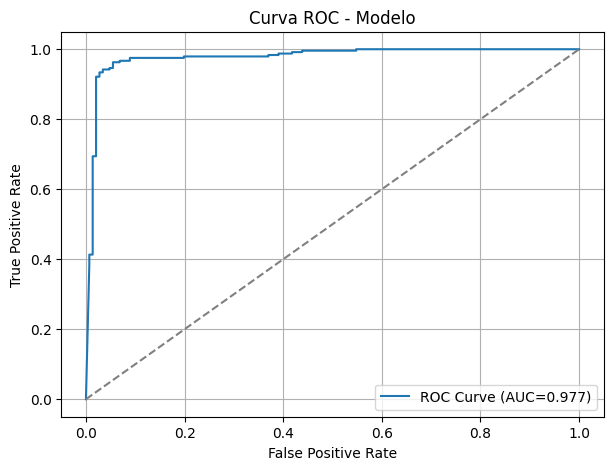


Mejor threshold (Youden): 0.6747


In [213]:
best_threshold = evaluar_modelo(model, X_val, y_val)

El modelo logra predecir con un formidable F1-Score (0.96), la pertenencia (1) a un centro poblado a partir de la capa de viviendas y la distancia del poligono.

# Exportación de Modelo de Entrenamiento y generalización para los tiles de test

In [215]:
import joblib

# Suponiendo que ya tienes:
# model  -> LogisticRegression entrenado
# best_threshold -> threshold que devolvió evaluar_modelo()

artifacts = {
    "model": model,
    "threshold": best_threshold
}

joblib.dump(artifacts, "modelo_ccpp_logistico.joblib")
print("✅ Modelo guardado en modelo_ccpp_logistico.joblib")

✅ Modelo guardado en modelo_ccpp_logistico.joblib


In [216]:
artifacts = joblib.load("modelo_ccpp_logistico.joblib")
model = artifacts["model"]
best_threshold = artifacts["threshold"]

In [217]:
import rasterio
from rasterio.features import shapes
from shapely.geometry import shape
import geopandas as gpd
import numpy as np

def raster_to_rural_polygons(raster_path, rural_value=2):
    """
    Lee un tif de predicción semántica y devuelve un GeoDataFrame
    con polígonos de la clase 'rural_value' (por defecto 2).
    """
    with rasterio.open(raster_path) as src:
        arr = src.read(1)
        transform = src.transform
        crs = src.crs

    # máscara: solo píxeles rurales
    mask = arr == rural_value

    polys = []
    vals = []

    for geom, val in shapes(arr, mask=mask, transform=transform):
        geom_shp = shape(geom)
        if geom_shp.is_empty:
            continue
        polys.append(geom_shp)
        vals.append(val)

    gdf = gpd.GeoDataFrame({"pred_class": vals, "geometry": polys}, crs=crs)
    return gdf

In [218]:
# ejemplo
gdf_polys_test = raster_to_rural_polygons("pred_ccpp_test.tif",
                                          rural_value=2)  # ajusta área mínima si quieres


Construcción del dataset a partir de la capa de viviendas en los tiles de test

In [223]:
gdf_points_test = test_viviendasxcentropoblados.copy()

In [225]:
def nearest_point_bruteforce(poly, gdf_points):
    distances = gdf_points.geometry.apply(lambda pt: poly.distance(pt))
    nearest_idx = distances.idxmin()
    nearest_row = gdf_points.loc[nearest_idx]
    dist = distances.loc[nearest_idx]
    return nearest_row, dist

def build_test_df(gdf_polys_test, gdf_points_test, id_col="IDCCPP_17"):
    """
    Para cada polígono predicho:
    - busca el punto de vivienda más cercano
    - guarda ID del punto, distancia
    """
    results = []
    for idx, row in gdf_polys_test.iterrows():
        poly = row.geometry
        nearest, dist = nearest_point_bruteforce(poly, gdf_points_test)
        point_id = str(nearest[id_col])
        results.append((idx, point_id, dist))

    df = pd.DataFrame(results, columns=["poly_index", "nearest_point_IDCCPP", "distance_m"])
    return df

# Asegúrate de que CRS coincidan
gdf_points_test = gdf_points.to_crs(gdf_polys_test.crs)

df_test = build_test_df(gdf_polys_test, gdf_points_test, id_col="IDCCPP_17")

In [ ]:
# Features
X_test = df_test[["distance_m"]]

# Probabilidades de pertenecer a un CCPP (label=1)
y_prob = model.predict_proba(X_test)[:, 1]

# Predicción binaria con tu threshold óptimo
df_test["pred_label"] = (y_prob >= best_threshold).astype(int)

# Asignar ID: si 1 → ID del punto; si 0 → "desconocido"
df_test["IDCCPP_pred"] = df_test.apply(
    lambda r: r["nearest_point_IDCCPP"] if r["pred_label"] == 1 else "desconocido",
    axis=1
)

In [228]:
# Unir por poly_index
gdf_polys_test = gdf_polys_test.reset_index().rename(columns={"index": "poly_index"})
gdf_pred = gdf_polys_test.merge(df_test, on="poly_index")

# Ahora gdf_pred tiene:
# geometry, pred_class, distance_m, pred_label, IDCCPP_pred

In [229]:
# Disolver por ID predicho
gdf_dissolved = gdf_pred.dissolve(by="IDCCPP_pred", as_index=False)

# Opcional: separar desconocidos
gdf_conocidos = gdf_dissolved[gdf_dissolved["IDCCPP_pred"] != "desconocido"]
gdf_desconocidos = gdf_dissolved[gdf_dissolved["IDCCPP_pred"] == "desconocido"]

In [230]:
# GeoPackage
gdf_dissolved.to_file("centros_poblados_pred_test.gpkg", layer="ccpp_pred", driver="GPKG")

# o Shapefile
#gdf_dissolved.to_file("centros_poblados_pred.shp")
print("✅ Capa exportada: centros_poblados_pred.gpkg")

✅ Capa exportada: centros_poblados_pred.gpkg


# PRUEBA FINAL: DETERMINACIÓN DE IOU POR POLÍGONO

In [254]:
test_geometrias_centros_poblados_validas_rural = gpd.overlay(
    poligonos_geometrias_centros_poblados_validas_rural,
    testsplit,
    how="intersection"
)

In [255]:
test_geometrias_centros_poblados_validas_rural = \
test_geometrias_centros_poblados_validas_rural[
    test_geometrias_centros_poblados_validas_rural.IDCCPP_17 != '9999'
]

In [268]:
real_test_dissolved = test_geometrias_centros_poblados_validas_rural.dissolve(by="IDCCPP_17", as_index=False)

In [256]:
gdf_dissolved_test = gpd.overlay(
    gdf_dissolved[gdf_dissolved.IDCCPP_pred != "desconocido"],
    testsplit,
    how="intersection"
)


C:\Users\Rofer\AppData\Local\Temp\ipykernel_6404\1586189359.py:1: UserWarning: `keep_geom_type=True` in overlay resulted in 22 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  gdf_dissolved_test = gpd.overlay(


In [287]:
def compute_iou_by_ccpp(real_test_dissolved, gdf_dissolved_test,
                        real_id="IDCCPP_17",
                        pred_id="IDCCPP_pred"):
    """
    Calcula IoU entre CCPP REALES y PREDICHOS, ambos ya disueltos.
    """

    # 1️⃣ Spatial join (real ← pred)
    pairs = gpd.sjoin(
        real_test_dissolved,
        gdf_dissolved_test,
        how="inner",
        predicate="intersects",
        lsuffix="real",
        rsuffix="pred"
    )

    rows = []

    for _, row in pairs.iterrows():
        # geometría REAL siempre está en 'geometry'
        real_geom = row["geometry"]

        # geometría PREDICHA recuperada por índice
        pred_index = row["index_pred"]
        pred_geom = gdf_dissolved_test.loc[pred_index].geometry

        # IDs reales y predichos
        real_id_val = row[real_id]
        pred_id_val = row[pred_id]

        # IoU
        inter = real_geom.intersection(pred_geom).area
        union = real_geom.union(pred_geom).area
        iou = inter / union if union > 0 else 0

        rows.append({
            "real_ID": real_id_val,
            "pred_ID": pred_id_val,
            "IoU": iou,
            "area_real": real_geom.area,
            "area_pred": pred_geom.area,
            "intersection_area": inter,
            "union_area": union
        })

    df = pd.DataFrame(rows)
    df = df.sort_values("IoU", ascending=False).reset_index(drop=True)

    return df

In [290]:
df_iou = compute_iou_by_ccpp(
    real_test_dissolved,
    gdf_dissolved_test,
    real_id="IDCCPP_17",
    pred_id="IDCCPP_pred"
)

In [ ]:
df_iou

,real_ID,pred_ID,IoU,area_real,area_pred,intersection_area,union_area
0,1402010025,1402010025,0.605147,1125.162815,833.49,738.420411,1220.232403
1,1403010020,1403010020,0.602312,1618.396588,1114.26,1027.210250,1705.446338
2,1402060010,1402060010,0.561121,13258.470013,10927.49,8693.273048,15492.686965
3,1402050038,1402050038,0.556676,10534.586763,11471.39,7869.459918,14136.516845
4,1403010059,1403010059,0.508402,7439.568446,8330.00,5315.081552,10454.486894
5,1402060011,1402060011,0.488823,6234.034738,7986.51,4669.007128,9551.537610
6,1403010021,1403010021,0.477834,20538.212708,31923.01,16962.486438,35498.736270
7,1402010004,1402010004,0.477485,25809.868081,17855.11,14111.394425,29553.583657
8,1402010003,1402010003,0.466721,1057.228755,607.11,529.604702,1134.734053
9,1402010002,1402010002,0.462682,274.719726,168.56,140.220193,303.059532


In [ ]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from shapely.geometry import Polygon, MultiPolygon, GeometryCollection
import numpy as np

def get_polygons(geom):
    polys = []
    if geom.is_empty:
        return polys

    if isinstance(geom, Polygon):
        return [geom]

    if isinstance(geom, MultiPolygon):
        return list(geom.geoms)

    if isinstance(geom, GeometryCollection):
        for g in geom.geoms:
            polys.extend(get_polygons(g))
        return polys
    
    try:
        for g in geom:
            polys.extend(get_polygons(g))
        return polys
    except:
        return polys
    plt.show()

In [300]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon, GeometryCollection

def plot_real_pred_intersection(real_gdf, pred_gdf, real_id_value, pred_id_value,
                                real_id="IDCCPP_17", pred_id="IDCCPP_pred",
                                figsize=(8,8)):
    
    # geometría real unida
    real_geom = real_gdf.loc[ real_gdf[real_id] == real_id_value ].geometry.unary_union
    
    # geometría pred unida
    pred_geom = pred_gdf.loc[ pred_gdf[pred_id] == pred_id_value ].geometry.unary_union

    # intersección
    inter = real_geom.intersection(pred_geom)

    # convertir todo a LISTAS DE POLYGONS
    real_polys = get_polygons(real_geom)
    pred_polys = get_polygons(pred_geom)
    inter_polys = get_polygons(inter)

    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # REAL (rojo)
    for poly in real_polys:
        xs, ys = poly.exterior.xy
        ax.fill(xs, ys, color='red', alpha=0.4, label='Real')

    # PREDICHO (azul)
    for poly in pred_polys:
        xs, ys = poly.exterior.xy
        ax.fill(xs, ys, color='blue', alpha=0.4, label='Predicho')

    # INTERSECCIÓN (morado)
    for poly in inter_polys:
        xs, ys = poly.exterior.xy
        ax.fill(xs, ys, color='purple', alpha=0.6, label='Intersección')

    ax.set_aspect('equal')
    ax.set_title(f"Real {real_id_value} vs Pred {pred_id_value}")
    ax.legend()
    plt.show()


C:\Users\Rofer\AppData\Local\Temp\ipykernel_6404\3006815044.py:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  real_geom = real_gdf.loc[ real_gdf[real_id] == real_id_value ].geometry.unary_union
C:\Users\Rofer\AppData\Local\Temp\ipykernel_6404\3006815044.py:12: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  pred_geom = pred_gdf.loc[ pred_gdf[pred_id] == pred_id_value ].geometry.unary_union


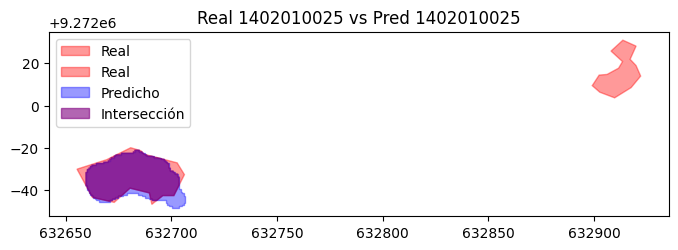

In [301]:
row = df_iou.iloc[0]

plot_real_pred_intersection(
    real_test_dissolved,
    gdf_dissolved_test,
    real_id_value=row.real_ID,
    pred_id_value=row.pred_ID
)


# PREDICCIONES FINALES

In [ ]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import reshape_as_image
import numpy as np

def normalize_raster(img):
    """
    Normaliza un raster a rango 0-255 para poder visualizarlo con matplotlib.
    """
    img = img.astype(float)
    min_val = np.nanmin(img)
    max_val = np.nanmax(img)
    if max_val - min_val == 0:
        return np.zeros_like(img)
    img_norm = (img - min_val) / (max_val - min_val)
    return (img_norm * 255).astype(np.uint8)


In [340]:
def plot_multiple_ccpp_with_raster(
        real_gdf, pred_gdf, raster_path, df_pairs,
        n=10, real_col="IDCCPP_17", pred_col="IDCCPP_pred"):

    rows = df_pairs.head(n)

    fig, axes = plt.subplots(2, 5, figsize=(20, 14))
    axes = axes.flatten()

    with rasterio.open(raster_path) as src:
        raster_crs = src.crs

    for ax, (_, row) in zip(axes, rows.iterrows()):

        real_geom = real_gdf.loc[real_gdf[real_col] == row.real_ID].geometry.union_all()
        pred_geom = pred_gdf.loc[pred_gdf[pred_col] == row.pred_ID].geometry.union_all()
        inter_geom = real_geom.intersection(pred_geom)

        # Combine all geometries to get bounding box
        union_geom = real_geom.union(pred_geom)

        minx, miny, maxx, maxy = union_geom.bounds

        # --- Cargar raster ---
        with rasterio.open(raster_path) as src:

            try:
                window = rasterio.windows.from_bounds(minx, miny, maxx, maxy, src.transform)
                img = src.read(window=window)

                # Verificar si img está vacío
                if img.size == 0:
                    img = None
                else:
                    img = normalize_raster(img)

                    # single band → convert to RGB
                    if img.ndim == 2:
                        img = np.stack([img]*3, axis=-1)
                    elif img.shape[0] == 1:
                        img = np.repeat(img, 3, axis=0)
                        img = reshape_as_image(img)
                    else:
                        img = reshape_as_image(img)

            except:
                img = None

        # ---- SET EXTENT para que los polígonos SIEMPRE se vean ----
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)

        # ---- Raster debajo ----
        if img is not None:
            ax.imshow(img, extent=(minx, maxx, miny, maxy), origin='upper')

        # ---- Geometrías encima ----
        for poly in get_polygons(real_geom):
            xs, ys = poly.exterior.xy
            ax.fill(xs, ys, color="red", alpha=0.35)

        for poly in get_polygons(pred_geom):
            xs, ys = poly.exterior.xy
            ax.fill(xs, ys, color="blue", alpha=0.35)

        for poly in get_polygons(inter_geom):
            xs, ys = poly.exterior.xy
            ax.fill(xs, ys, color="purple", alpha=0.55)

        ax.set_title(f"Centro Poblado {row.pred_ID}\nIoU={row.IoU:.2f}")
        ax.set_aspect("equal")
        ax.axis("off")

    # LEYENDA GLOBAL
    fig.legend(
        handles=[
            plt.Line2D([0], [0], color="red", lw=12, alpha=0.5, label="Real"),
            plt.Line2D([0], [0], color="blue", lw=12, alpha=0.5, label="Predicho"),
            plt.Line2D([0], [0], color="purple", lw=12, alpha=0.7, label="Intersección"),
        ],
        loc="lower center",
        ncol=3,
        fontsize=14,
        frameon=False,
        bbox_to_anchor=(0.5, -0.03)
    )

    plt.tight_layout()
    plt.show()

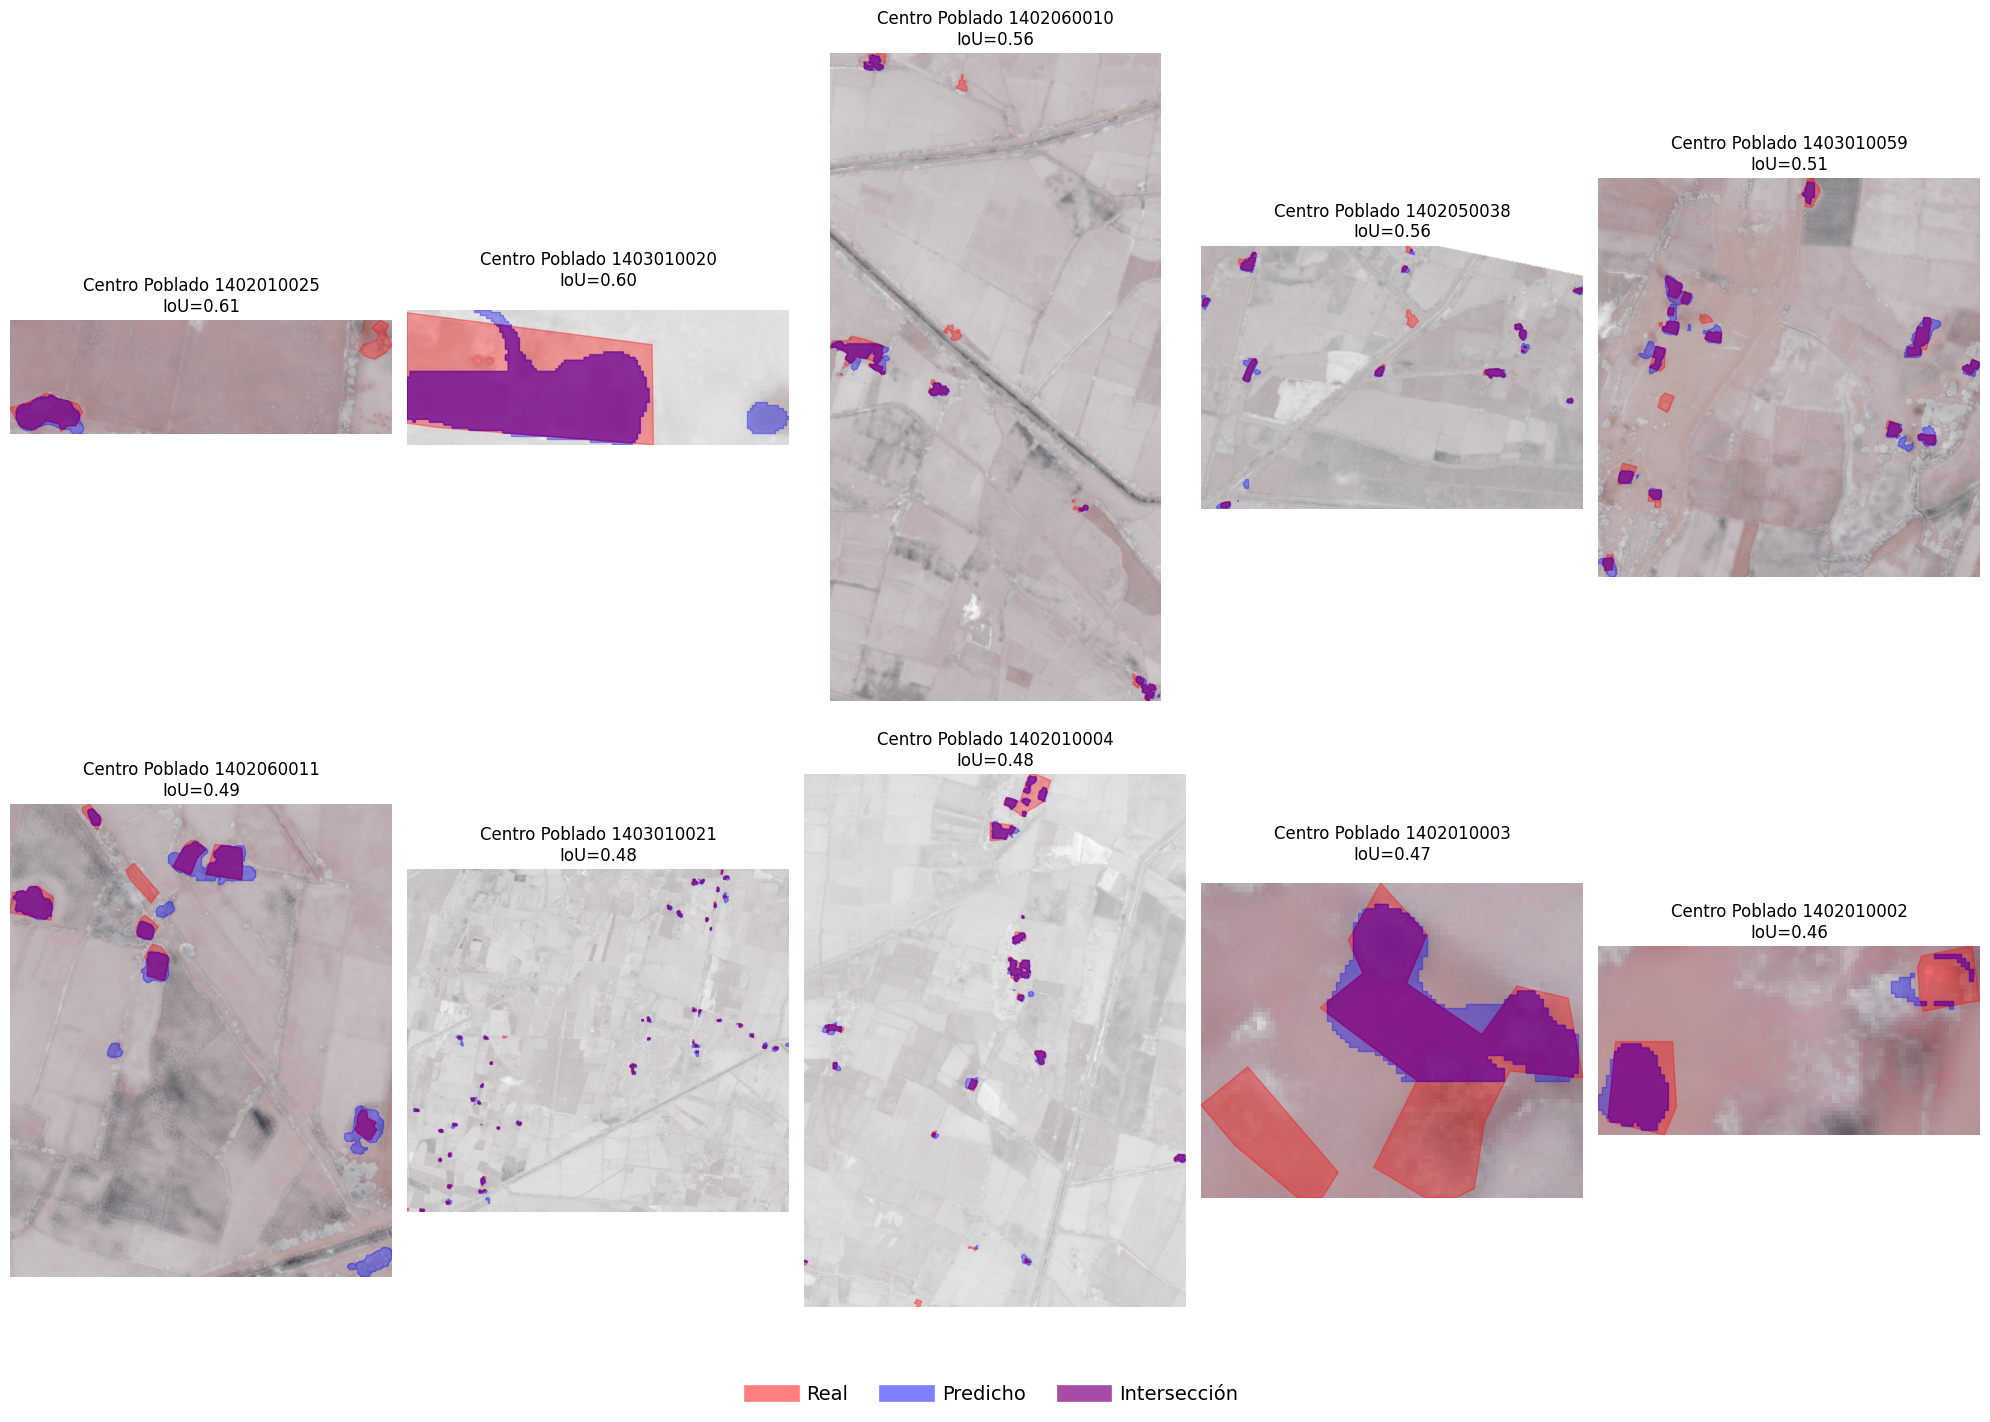

In [341]:
plot_multiple_ccpp_with_raster(
    real_test_dissolved,
    gdf_dissolved_test,
    raster_path="perusat_recortado.tif",
    df_pairs=df_iou,      # tabla IoU
    n=10                  # mostrar 6 mejores
)